In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


n_steps = 1500
n_features = 5
noise_std = 0.3


t = np.arange(n_steps)


feature_1 = 0.02 * t + 5 * np.sin(0.02 * t)
feature_2 = 3 * np.sin(0.1 * t) + 0.5 * np.sin(0.03 * t + 1)
feature_3 = 0.5 * t**0.2 + 2 * np.cos(0.05 * t)
feature_4 = np.sin(0.015 * t) * np.cos(0.1 * t) * 10
feature_5 = np.random.randn(n_steps).cumsum() * 0.1 + 2 * np.sin(0.05 * t)


features = np.vstack([
    feature_1 + np.random.normal(0, noise_std, n_steps),
    feature_2 + np.random.normal(0, noise_std, n_steps),
    feature_3 + np.random.normal(0, noise_std, n_steps),
    feature_4 + np.random.normal(0, noise_std, n_steps),
    feature_5 + np.random.normal(0, noise_std, n_steps),
]).T


df = pd.DataFrame(features, columns=[f"feature_{i}" for i in range(1, 6)])
df.head()


,feature_1,feature_2,feature_3,feature_4,feature_5
0,0.155030,-0.086511,2.063036,-0.061097,-0.465726
1,0.292395,0.479236,2.741777,-0.083553,-0.371404
2,0.000153,1.224915,1.961279,0.377245,0.344890
3,-0.138600,0.996771,2.421236,0.135919,0.936723
4,0.556874,1.651274,2.221893,0.251370,0.969099


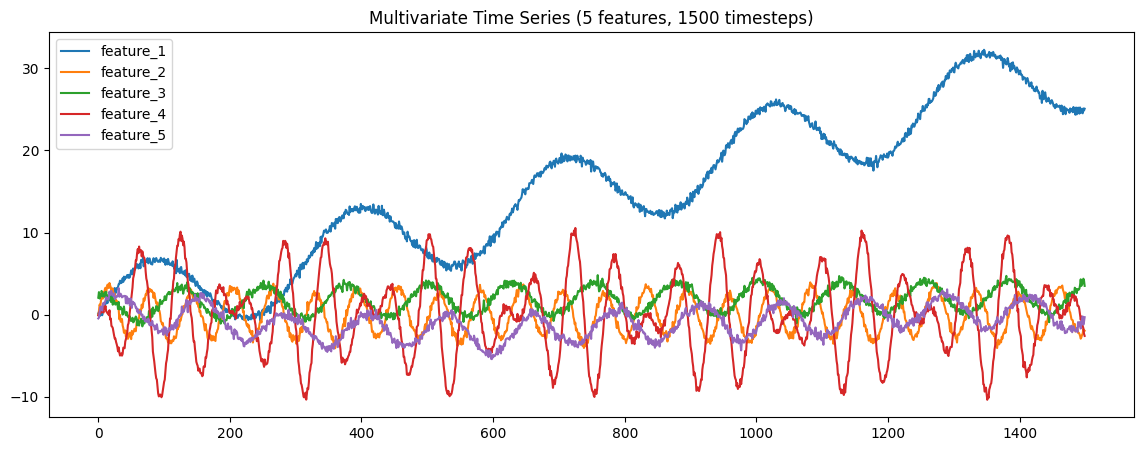

In [2]:
df.plot(figsize=(14,5))
plt.title("Multivariate Time Series (5 features, 1500 timesteps)")
plt.show()


In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


input_length = 60
forecast_horizon = 10


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

X = []
y = []


for i in range(len(scaled_data) - input_length - forecast_horizon):
    X.append(scaled_data[i : i + input_length])
    y.append(scaled_data[i + input_length : i + input_length + forecast_horizon, 0])


X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1430, 60, 5)
y shape: (1430, 10)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer="random_normal")
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[-1],),
                                 initializer="zeros")
        super().build(input_shape)

    def call(self, inputs):

        e = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)


        alphas = tf.nn.softmax(e, axis=1)


        context = tf.reduce_sum(inputs * alphas, axis=1)

        return context, alphas



input_layer = layers.Input(shape=(input_length, 5))


lstm_out = layers.LSTM(64, return_sequences=True)(input_layer)


context_vector, attention_weights = AttentionLayer()(lstm_out)

output = layers.Dense(forecast_horizon)(context_vector)

model = models.Model(inputs=input_layer, outputs=output)


model.compile(optimizer="adam", loss="mse")

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ [(None, 64), (None,    │         4,160 │
│ (AttentionLayer)                │ 60, 64)]               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,730 (88.79 KB)

 Trainable params: 22,730 (88.79 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:

split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)


Train shapes: (1144, 60, 5) (1144, 10)
Test shapes: (286, 60, 5) (286, 10)
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1125 - val_loss: 0.0343
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0111 - val_loss: 0.0074
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0060 - val_loss: 0.0102
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0058 - val_loss: 0.0086
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0044 - val_loss: 0.0060
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0047 - val_loss: 0.0105
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0032 - val_loss: 0.0100
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0019 - val_l

In [7]:

sample_id = 0

X_sample = X_test[sample_id:sample_id+1]
y_true = y_test[sample_id]


y_pred = model.predict(X_sample)[0]

print("TRUE:", y_true)
print("PRED:", y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
TRUE: [0.62495586 0.61880266 0.61601522 0.6087359  0.62544485 0.62666242
 0.63117932 0.64274941 0.63784011 0.64105274]
PRED: [0.65844274 0.6565528  0.6530801  0.648474   0.64850986 0.65538824
 0.6614003  0.6528119  0.6694431  0.6491493 ]


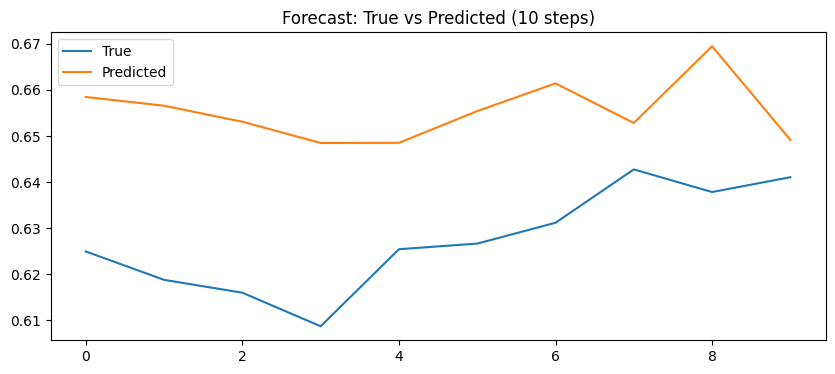

In [8]:
plt.figure(figsize=(10,4))
plt.plot(y_true, label="True")
plt.plot(y_pred, label="Predicted")
plt.title("Forecast: True vs Predicted (10 steps)")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


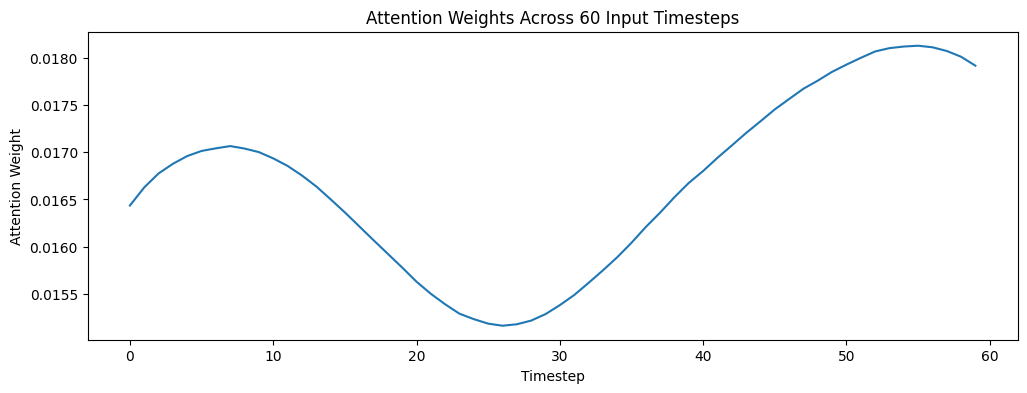

In [9]:

attention_model = models.Model(inputs=model.input,
                               outputs=model.layers[2].output[1])

attention_scores = attention_model.predict(X_sample)[0]
attention_scores = attention_scores.mean(axis=1)

plt.figure(figsize=(12,4))
plt.plot(attention_scores)
plt.title("Attention Weights Across 60 Input Timesteps")
plt.xlabel("Timestep")
plt.ylabel("Attention Weight")
plt.show()


In [12]:
model.save("advanced_timeseries_forecasting.h5")


In [13]:
from google.colab import files
files.download("advanced_timeseries_forecasting.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
df.to_csv("timeseries_data.csv", index=False)
files.download("timeseries_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import joblib
joblib.dump(scaler, "scaler.pkl")
files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>